In [1]:
import fun as f
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx
import scipy.linalg as la
from sklearn import cluster, datasets
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

# 1- Half-moon Dataset

In [2]:
#Generate data
Npts = 35
half_moons_data = datasets.make_moons(n_samples=Npts, noise=.040, random_state=1991)
nodes_position = dict()
for key  in [i for i in range(Npts)]:
    nodes_position[key] = list(half_moons_data[0][key])

In [3]:
W_half_moon = f.adjacency_matrix(half_moons_data[0], sigma=0.5)

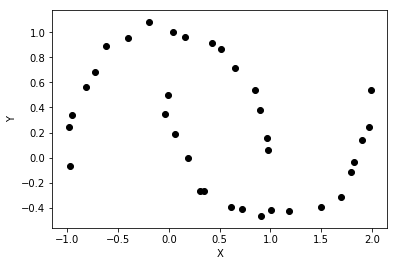

In [4]:
#plot data
f.scatter_plot_data_set(half_moons_data[0], half_moons_data[1], color_clusters = False)

## i) Fully connected graph 

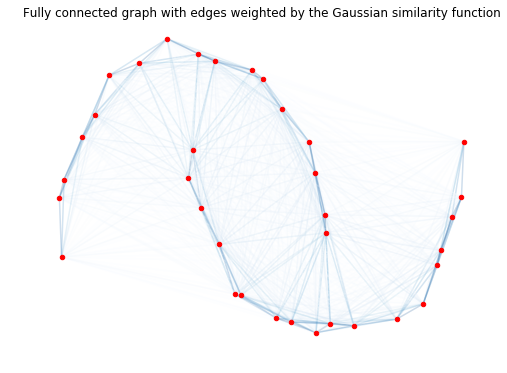

In [6]:
#create graph
hm = f.create_weighted_Graph(W_half_moon)
#Plot graph
f.plot_Graph(hm, nodes_position, 
               title = 'Fully connected graph with edges weighted by the Gaussian similarity function',alpha=0.2)

## ii) Mutual k-nearest neighbor graph

In [7]:
A = kneighbors_graph(half_moons_data[0], 3, mode='connectivity', include_self=False)
A= A.toarray()

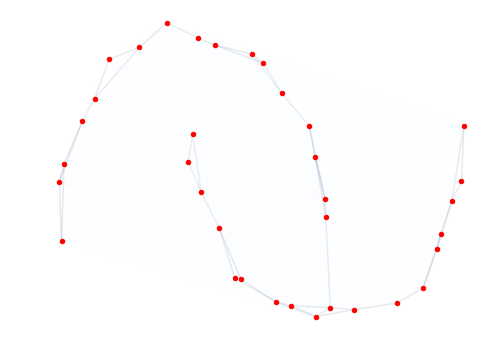

In [9]:
#create graph
km = f.create_weighted_Graph(A)
#Plot graph
f.plot_Graph(km, nodes_position, 
               title = '',alpha=0.1)

## K-means performance

In [10]:
kmeans = KMeans(n_clusters=2,random_state=0).fit(half_moons_data[0])

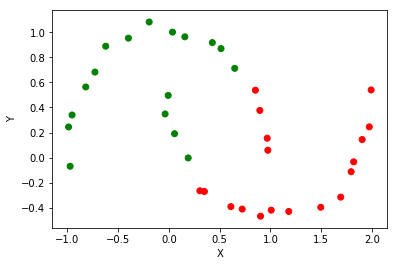

In [11]:
x, y = half_moons_data[0].T
colors = ['red','orange','blue',"green"]
plt.scatter(x,y,c=kmeans.labels_, 
        cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# 2- Spiral Dataset

In [12]:
# Toy dataset obtained from:
# https://www.gagolewski.com/resources/data/clustering/
data_path = 'data/spiral.data'
labels_path = 'data/spiral.labels'

In [13]:
data_points, data_labels = f.read_and_convert_data(data_path, labels_path)
Npts, coord = data_points.shape
nodes_position_spiral = dict()
for key  in [i for i in range(Npts)]:
    nodes_position_spiral[key] = list(data_points[key])

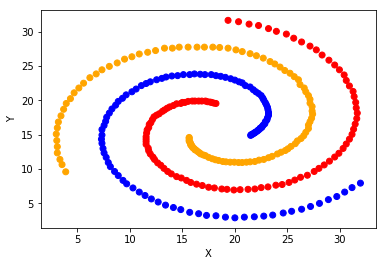

In [14]:
f.scatter_plot_data_set(data_points, data_labels)

In [15]:
scaled_data_points = data_points / 30.
scaled_W = f.adjacency_matrix(scaled_data_points, sigma=0.05)

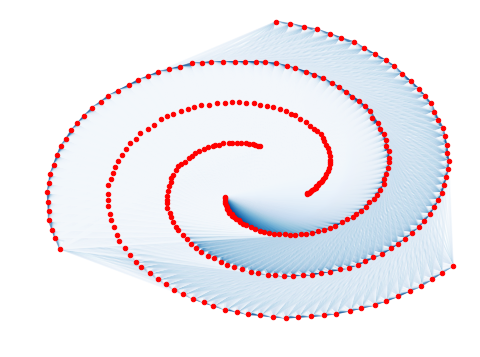

In [17]:
#create graph
scaled_spiral_graph = f.create_weighted_Graph(scaled_W)
#Plot graph
f.plot_Graph(scaled_spiral_graph, nodes_position_spiral, 
               title = '',node_size=20,alpha=0.2)

In [20]:
W = f.adjacency_matrix(data_points, sigma=0.5)

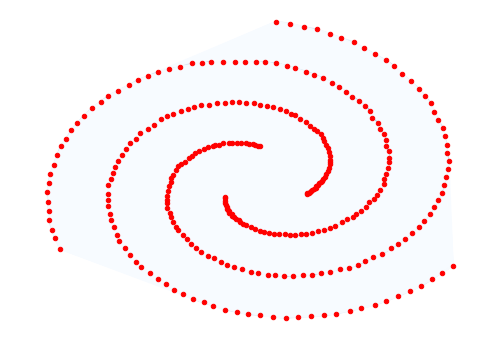

In [24]:
#create graph
spiral_graph = f.create_weighted_Graph(W)
#Plot graph
f.plot_Graph(spiral_graph, nodes_position_spiral, 
               title = '',node_size=20,alpha=0.8)

In [25]:
L_unnormalized = f.unnormalized_graph_Laplacian(W)
L_symmetric = f.normalized_graph_Laplacian(W, matrix = "symmetric")
L_random_walk = f.normalized_graph_Laplacian(W, matrix = "rw")

In [26]:
#Sanity check: Symmetric matrix
L_unnormalized.shape
np.allclose(L_unnormalized, L_unnormalized.T)
#np.matmul(L_unnormalized, np.ones(L_unnormalized.shape[0]).reshape(L_unnormalized.shape[0], 1))

True

## Compute eigenvalues-eigenvectors

In [27]:
eigenvalues, eigenvectors = la.eig(L_unnormalized)
eigenvalues = eigenvalues.real
rearrangedEvalsVecs = sorted(zip(eigenvalues,eigenvectors.T),key=lambda x: x[0])
eigenvalues.sort()

## Multiplicity of the first eigenvalue

In [28]:
np.where(eigenvalues < 1e-8)[0].shape[0]

3

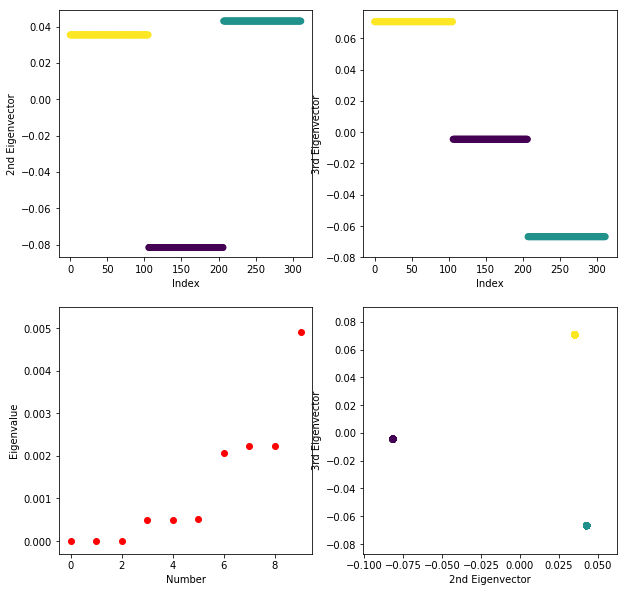

In [29]:
fig = plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.scatter([i for i in range(Npts)], rearrangedEvalsVecs[1][1],c=data_labels)
plt.xlabel ('Index')
plt.ylabel ('2nd Eigenvector')
plt.ylim(-0.087, 0.049)

plt.subplot(2, 2, 2)
plt.scatter([i for i in range(Npts)], rearrangedEvalsVecs[2][1],c=data_labels)
plt.xlabel ('Index')
plt.ylabel ('3rd Eigenvector')
plt.ylim(-0.08, 0.078)

plt.subplot(2, 2, 3)
plt.scatter([i for i in range(10)], eigenvalues[0:10],c="red")
plt.ylim(-0.0003, 0.0055)
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')

plt.subplot(2, 2, 4)
plt.scatter(rearrangedEvalsVecs[1][1], rearrangedEvalsVecs[2][1],c=data_labels)
plt.xlabel ('2nd Eigenvector')
plt.ylabel ('3rd Eigenvector')

plt.show()

Text(0, 0.5, 'Eigenvalue')

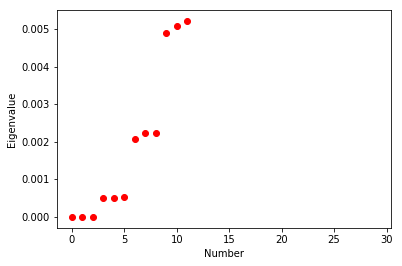

In [31]:
plt.scatter([i for i in range(30)], eigenvalues[0:30],c="red")
plt.ylim(-0.0003, 0.0055)
plt.xlabel ('Number')
plt.ylabel ('Eigenvalue')

### From the first row figures, why does the eigenvectors look like that? Why do we move from one to two steps?

### Why does the projection of the 2nd 3rd eigenvector components are overlap into a single point?